# Сравнение классификаторов

Суть задания состоит в том, чтобы сравнить различные классификаторы на наборе данных Extended MNIST https://www.nist.gov/itl/products-and-services/emnist-dataset. <br>
Набор одержит монохромные изображения латинских букв. <br>
На каждом изображении содержится по одной букве в низком разрешении (28 на 28 пикселей). <br>
<br>
Нужно использовать 88,800 изображений для обучения и 14,800 изображений, чтобы проверить качество классификации. <br>
При тестировании следует применить различные модели, включая (но не ограничиваясь): <br>
-- KNeighborsClassifier <br>
-- LogisticRegression <br>
-- Naive Bayes <br>
-- Bayesian Classifier <br>
-- Linear SVC <br>
-- DecisionTreeClassifier <br>
<br>
В этой части требуется провести эксперименты с различными моделями и гиперпараметрами моделей. <br>
Оценить качество классификаторов и сравнить их друг с другом по различным метрикам (не только по основной метрике соревнования).<br>
<br>
Попробуйте уменьшить размерность пространства при помощи PCA (или других аналогичных) методов и сравнить результаты до и после уменьшения размерности.<br>

## Подготовка данных

### Чтение файлов csv

In [3]:
import shutil
shutil.unpack_archive("emnist-letters-data.csv.zip", "")

ReadError: Unknown archive format 'emnist-letters-data.csv.7z'

In [216]:
import pandas as pd
import numpy as np

# Load test data
X_exam = pd.read_csv('emnist-letters-test-data.csv', index_col=0)
X_exam = X_exam.to_numpy()

# Load train data
X_trainFull = pd.read_csv('emnist-letters-train-data.csv', header=None)

# separate column w/ predicts
y_trainFull = pd.DataFrame(X_trainFull[0])
y_trainFull.columns=['Y']

X_trainFull = X_trainFull.drop(columns={0})

# convert from pandas to numpy array
X_trainFull = X_trainFull.to_numpy()
y_trainFull = y_trainFull.to_numpy().T[0]

### Выводим изображения букв

In [ ]:
import matplotlib.pyplot as plt

In [217]:
# Функция для вывода буквы на ось из линейного массива
def printLetter(ax, pic28x28, title = ""):
    pic28x28 = np.array(pic28x28).reshape((28,28))
    ax.imshow(pic28x28, cmap='gist_gray')
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    if len(title) != 0:
        ax.set_title(title)

In [ ]:
# Функция для вывода 52 случайных букв из массива Х
def printSomeLetters(X):
    lettersPrintList = [0, 1]
    fig, axes = plt.subplots(4, 13, figsize=(20, 7))
    for yUnique in np.unique(y_trainFull):
        for i in lettersPrintList:
            ax = axes.ravel()[i + len(lettersPrintList) * (yUnique-1)]
            printLetter(ax, X[ np.random.randint( len(X) ) ])

#### Выводим изображения букв и набора для обучения

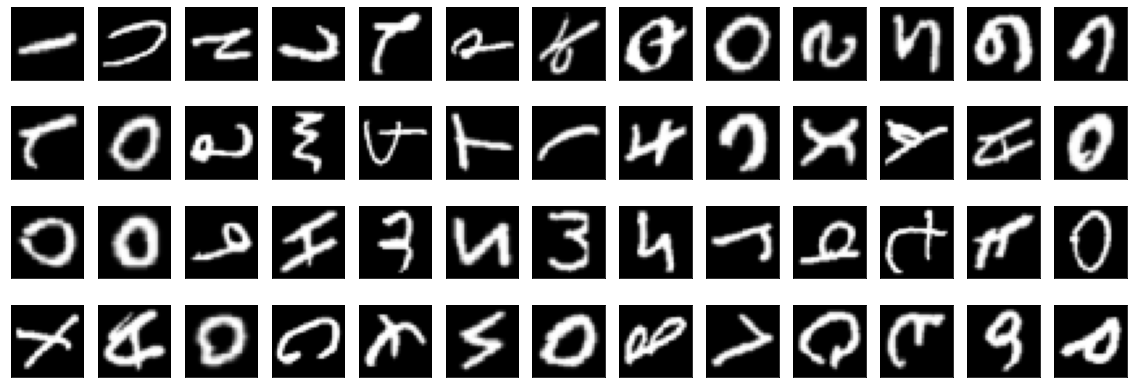

In [215]:
printSomeLetters(X_trainFull)

##### Буквы выглядят повернутыми, транспонируем матрицы изображений

In [218]:
for i, X in enumerate(X_trainFull):
    X_trainFull[i] = np.array(X).reshape((28, 28)).T.ravel()

##### Повторно выводим буквы из набора для обучения

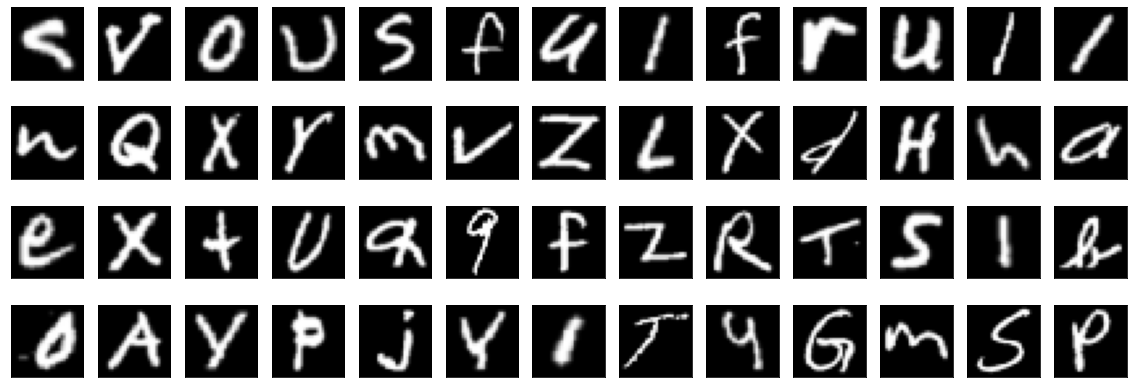

In [219]:
printSomeLetters(X_trainFull)

#### Выводим изображения букв и набора для проверки

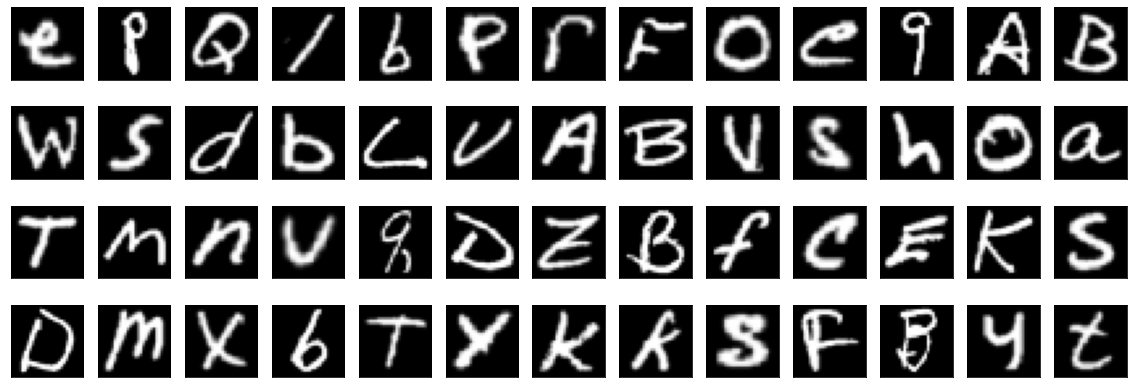

In [212]:
printSomeLetters(X_exam)

### Разбиваем набор для обучения на тренировочный и валидационный
80% набора - для тренировки, 20% для валидации

In [106]:
_TrainingSetSize = int(len(X_trainFull) * 0.80)
X_train = X_trainFull[:_TrainingSetSize]
X_test = X_trainFull[_TrainingSetSize:]
y_train = y_trainFull[:_TrainingSetSize]
y_test = y_trainFull[_TrainingSetSize:]

### Utility Functions

In [116]:
# Функция для построения непрерывный график по точкам
# ax - ось, для отображения графика
# data - точки, Y  

def PlotScoreGraph(ax, dataY, dataX = []):
        nData = len(dataY)
        if dataX == []:
                dataX = np.arange(1,nData + 1) # соответсвие каждому Y и его индексу если X пуст

        ax.plot(
                dataY, 
                marker='o',
                color='red'
                )

        dataMin, dataMax = np.min(dataY), np.max(dataY)

        ax.grid(True)
        minScale, maxScale = 0.95, 1.05 
        ax.set_yticks(np.linspace(dataMin * minScale, dataMax * maxScale, 10))
        ax.set_xticks(dataX - 1)
        ax.set_xticklabels(dataX)

        ax.set_ylim(dataMin * minScale, dataMax * maxScale)
        ax.set_xlim(-1, nData)

        ax.tick_params(
                axis = 'both', 
                which = 'major',
                direction = 'inout',
                bottom = False,
                top = False,
                left = False,
                right = False
                )

In [ ]:
# Функция для получения времени обучения, времени работы, предикта
from timeit import default_timer as dtimer

def GetModelPrediction(classifier):
    start_time = dtimer()
    classifier.fit(X_train, y_train)
    timeToFit = dtimer() - start_time
    
    start_time = dtimer()
    predict = classifier.predict(X_test)
    timeToPredict = dtimer() - start_time

    return [timeToFit, timeToPredict, predict]

In [103]:
# Функция для расчета графика зависимости размера тренировочной выборки на точность
def PlotTrainingCurve(classifierInit, X_trainIn, y_trainIn, X_testIn, y_testIn):
    _TrainingSize = np.linspace(10, len(y_trainIn), 12, dtype=np.int32)
    scoreTest = []
    scoreTrain = []
    for _size in _TrainingSize:
        classifier = classifierInit
        X_trainPart = X_trainIn[:_size]
        y_trainPart = y_trainIn[:_size]
        classifier.fit(X_train, y_train)
        scoreTest.append(classifier.score(X_testIn, y_testIn))
        scoreTrain.append(classifier.score(X_trainPart, y_trainPart))

    fig, ax = plt.subplots(figsize=(6, 7))
    ax.plot(_TrainingSize, scoreTrain, marker='o', color='blue')
    ax.plot(_TrainingSize, scoreTest, marker='o', color='green')
    ax.legend(["Train", "Test"],loc=1)
    ax.set(title="Training Set Size to Score",
            xlabel="Size",
            ylabel="Score")
    ax.set_xticks(_TrainingSize)

In [ ]:
# Функция для получения статистических метрик из предсказания
from sklearn import metrics

def calcMetrics(y_predict, y_true):
    metrics.accuracy_score(y_true, y_predict)
    metrics.f1_score(y_true, y_predict)
    metrics.recall_score(y_true, y_predict)
    metrics.precision_score(y_true, y_predict)

## Уменьшение размерности. PCA.

## KNeighborsClassifier

In [10]:
from sklearn.neighbors import KNeighborsClassifier as KNeighborsClassifier # 

In [22]:
scoresKNN, timesFitKNN, timesScoreKNN = [], [], []
for k in list(range(1, 16)):
    classifier = KNeighborsClassifier(n_neighbors = k)
    
    timeToFit, timeToScore, score = GetModelPrediction(classifier=classifier)

    timesFitKNN.append(timeToFit)
    timesScoreKNN.append(timeToScore)
    scoresKNN.append(score)

In [23]:
print(timesFitKNN)
print(timesScoreKNN)
print(scoresKNN)

[0.2934134000006452, 0.11045670000021346, 0.13669109999955253, 0.11531939999986207, 0.1104527000006783, 0.11098690000108036, 0.12141410000003816, 0.13705389999995532, 0.13998680000077002, 0.12058450000040466, 0.12966009999945527, 0.1273825999996916, 0.1273758999996062, 0.13789710000128252, 0.12836849999985134]
[25.170964099999765, 26.20048079999924, 27.393055300000015, 34.81219679999958, 34.68721209999967, 34.69076470000073, 34.67238150000048, 34.84923909999998, 34.74651420000009, 34.77881979999984, 35.100330600000234, 34.96982470000148, 34.67572719999953, 34.649183300000004, 34.61189740000009]
[0.8387847222222222, 0.8287847222222222, 0.8441666666666666, 0.8426041666666667, 0.8435763888888889, 0.8405555555555555, 0.8389583333333334, 0.8384375, 0.8356944444444444, 0.8347916666666667, 0.8323611111111111, 0.8302083333333333, 0.8287847222222222, 0.8274305555555556, 0.8250347222222222]


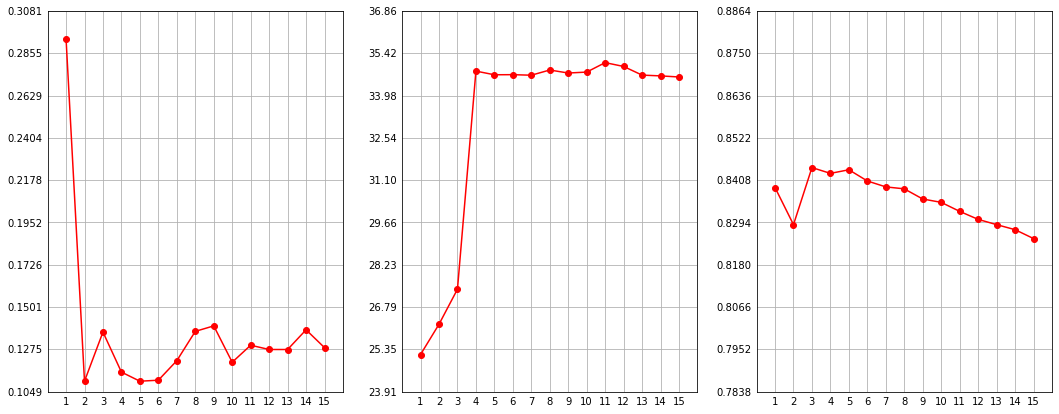

In [24]:
fg, ax = plt.subplots(1, 3, figsize=(18, 7))
PlotScoreGraph(ax[0], timesFitKNN)
PlotScoreGraph(ax[1], timesScoreKNN)
PlotScoreGraph(ax[2], scoresKNN)

In [ ]:
classifier = KNeighborsClassifier(n_neighbors = 3)
PlotTrainingCurve(classifier, X_train, y_train, X_test, y_test)

## LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression as LogisticRegression

In [65]:
scoresLR, timesFitLR, timesScoreLR = [], [], []
for k in list(range(1, 3)):
    classifier = LogisticRegression(max_iter=100*10*k)
    
    timeToFit, timeToScore, score = GetModelPrediction(classifier=classifier)

    timesFitLR.append(timeToFit)
    timesScoreLR.append(timeToScore)
    scoresLR.append(score)

NameError: name 'LogisticRegression' is not defined

In [ ]:
print(timesFitLR)
print(timesScoreLR)
print(scoresLR)

In [ ]:
fg, ax = plt.subplots(1, 3, figsize=(18, 7))
PlotScoreGraph(ax[0], timesFitLR)
PlotScoreGraph(ax[1], timesScoreLR)
PlotScoreGraph(ax[2], scoresLR)

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB as NaiveBayes

In [ ]:
scoresNB, timesFitrNB, timesScorerNB = [], [], []
for k in list(range(1, 16)):
    classifier = NaiveBayes()

    timeToFit, timeToScore, score = GetModelPrediction(classifier=classifier)

    timesFitrNB.append(timeToFit)
    timesScorerNB.append(timeToScore)
    scoresNB.append(score)

In [ ]:
print(timesFitrNB)
print(timesScorerNB)
print(scoresNB)

In [ ]:
fg, ax = plt.subplots(1, 3, figsize=(18, 7))
PlotScoreGraph(ax[0], timesFitrNB)
PlotScoreGraph(ax[1], timesScorerNB)
PlotScoreGraph(ax[2], scoresNB)


## Bayesian Classifier

In [ ]:
from sklearn.naive_bayes import MultinomialNB as BayesianClassifier

In [ ]:
scoresrBC, timesFitrBC, timesScorerBC = [], [], []
for smoothing in np.linspace(0, 1, 10):
    classifier = BayesianClassifier(alpha=smoothing)

    score, timeToFit, timeToScore = GetModelPrediction(classifier=classifier)

    timesFitrBC.append(timeToFit)
    timesScorerBC.append(timeToScore)
    scoresrBC.append(score)

In [ ]:
print(timesFitrBC)
print(timesScorerBC)
print(scoresrBC)

In [ ]:
fg, ax = plt.subplots(1, 3, figsize=(18, 7))
PlotScoreGraph(ax[0], timesFitrBC)
PlotScoreGraph(ax[1], timesScorerBC)
PlotScoreGraph(ax[2], scoresrBC)

## Linear SVC

In [ ]:
from sklearn.svm import LinearSVC as LinearSVC

In [ ]:
scoresrSVC, timesFitrSVC, timesScorerSVC = [], [], []
for k in list(range(1, 16)):
    classifier = LinearSVC()
    
    score, timeToFit, timeToScore = GetModelPrediction(classifier=classifier)

    timesFitrSVC.append(timeToFit)
    timesScorerSVC.append(timeToScore)
    scoresrSVC.append(score)

In [ ]:
print(scoresrSVC)
print(timesFitrSVC)
print(timesScorerSVC)

In [ ]:
fg, ax = plt.subplots(1, 3, figsize=(18, 7))
PlotScoreGraph(ax[0], scoresrSVC)
PlotScoreGraph(ax[1], timesFitrSVC)
PlotScoreGraph(ax[2], timesScorerSVC)

## DecisionTreeClassifier

In [71]:
from sklearn.tree import DecisionTreeClassifier as DecisionTreeClassifier

In [72]:
scoresDTC, timesFitDTC, timesScoreDTC = [], [], []
for k in list(range(1, 16)):
    classifier = DecisionTreeClassifier(max_depth=k)
    
    timeToFit, timeToScore, score = GetModelPrediction(classifier=classifier)

    timesFitDTC.append(timeToFit)
    timesScoreDTC.append(timeToScore)
    scoresDTC.append(score)

In [73]:
print(scoresDTC)
print(timesFitDTC)
print(timesScoreDTC)

[0.7614140999994561, 1.3807049999995797, 2.0622364999999263, 2.8325462000002517, 3.716931900000418, 4.660593499999777, 5.67472589999943, 6.76698099999976, 7.986493899999914, 9.299540200000592, 10.477533600000243, 11.618919399999868, 12.654040200000054, 13.514877399999932, 14.257309699999496]
[0.053543099999842525, 0.047840500000347674, 0.05241939999996248, 0.0495506999995996, 0.049707000000125845, 0.04972120000002178, 0.05199209999955201, 0.05028160000074422, 0.053545499999927415, 0.052197500000147556, 0.05475340000066353, 0.05429619999995339, 0.05691050000041287, 0.05502450000039971, 0.05539339999995718]
[0.07409722222222222, 0.12399305555555555, 0.20857638888888888, 0.30875, 0.41184027777777776, 0.46569444444444447, 0.51375, 0.5671875, 0.6044791666666667, 0.6402430555555556, 0.6593055555555556, 0.6714236111111112, 0.6736458333333334, 0.6762152777777778, 0.6763888888888889]


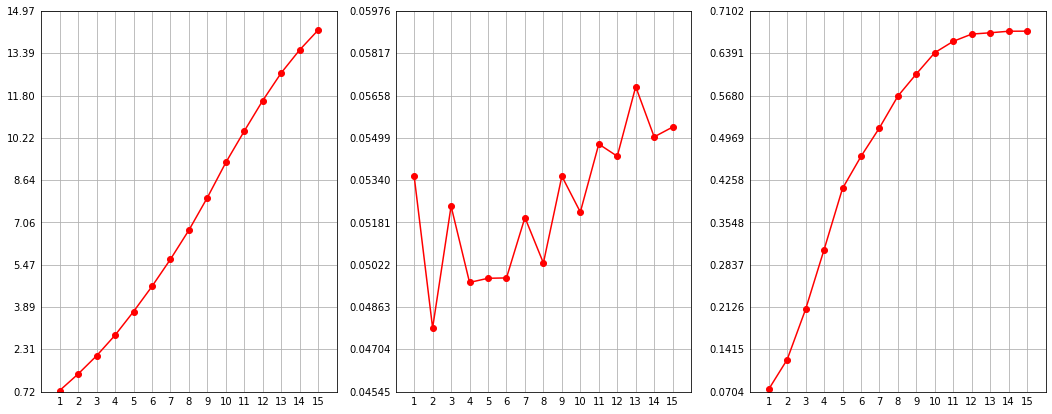

In [74]:
fg, ax = plt.subplots(1, 3, figsize=(18, 7))
PlotScoreGraph(ax[0], timesFitDTC)
PlotScoreGraph(ax[1], timesScoreDTC)
PlotScoreGraph(ax[2], scoresDTC)


## RandomForestClassifier

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
scoresRFC, timesFitRFC, timesScoreRFC = [], [], []
for k in list(range(1, 16)):
    classifier = RandomForestClassifier()

    timeToFit, timeToScore, score = GetModelPrediction(classifier=classifier)

    timesFitRFC.append(timeToFit)
    timesScoreRFC.append(timeToScore)
    scoresRFC.append(score)

In [20]:
print(timesFitRFC)
print(timesScoreRFC)
print(scoresRFC)

[48.36965579999969, 46.86212609999984, 46.9232834999998, 48.669824399999925, 53.042806700000256, 52.36426759999995, 53.02098380000007, 52.09997340000018, 52.39198189999979, 52.663464900000236, 52.9044957000001, 52.8849624999998, 53.01992770000015, 52.397230500000205, 52.09082559999979]
[1.2105028000000857, 1.3126631999998608, 1.2054692000001523, 1.5110147000000325, 1.5071248999997806, 1.4494168999999602, 1.4791086000000178, 1.4256368999999722, 1.4831710000003113, 1.477545199999895, 1.4379580999998325, 1.469105000000127, 1.4137688999999227, 1.4586349999999584, 1.3915049000002]
[0.8679861111111111, 0.8670138888888889, 0.8669097222222222, 0.8684027777777777, 0.8680555555555556, 0.8692708333333333, 0.8684722222222222, 0.8680902777777778, 0.8680902777777778, 0.8678472222222222, 0.8679861111111111, 0.8681597222222223, 0.8676736111111111, 0.8672916666666667, 0.8681597222222223]


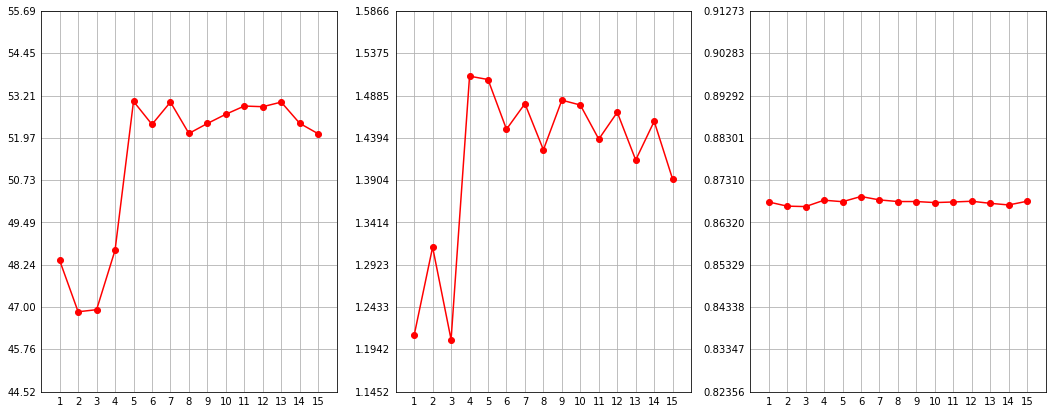

In [21]:
fg, ax = plt.subplots(1, 3, figsize=(18, 7))
PlotScoreGraph(ax[0], timesFitRFC)
PlotScoreGraph(ax[1], timesScoreRFC)
PlotScoreGraph(ax[2], scoresRFC)